* Overview
  * 카메라로 비춰진 사람 얼굴 이미지만으로 마스크를 제대로 썼는지, 쓰지 않았는지를 가려낸 것.
  * 아예 안쓴 것 뿐만 아니라 정확히 쓰지 않은 것도 탐지.

* Dataset
  * 4500명, 한 사람당 7장(5장은 마스크 착용, 이상하게 착용한 1장, 미착용 1장)의 사진을 가짐.
  * 384\*512 크기
  * 아시아인 남녀로 구성, 20\~70대로 구성.
  * 18개의 클래스 예측. (Wear, Incorrect, Not wear), (Male, Female), (<30, >=30 and <60, >=60)으로, 각각 마스크 착용여부, 성별, 나이로 구성되어있음.
  * train 60%, public test 20%, private test 20%으로 나뉘어짐.

# 데이터 준비

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import cv2

import os

In [3]:
train_path = os.path.join("input", "data", "train")
eval_path = os.path.join("input", "data", "eval")

In [4]:
df_train = pd.read_csv(os.path.join(train_path, "train.csv"))
df_eval = pd.read_csv(os.path.join(eval_path, "info.csv"))

In [52]:
# train dataset과 class mapping
all_images = []
for path in df_train["path"]:
    image_path = os.path.join(train_path, "images", path)
    all_images += [os.path.join(image_path, image_filename) for image_filename in os.listdir(image_path) if image_filename[0] != "."]
    
# assert len(all_images) == 2700*7

class_dict = {stat: i for i, stat in enumerate((Mask+Gender+Age) for Mask in ["Wear", "Incorrect", "NotWear"] for Gender in ["male", "female"] for Age in ["Under30", "30to60", "Overeq60"])}

category = []
class_masked = []
class_sex = []
class_age = []
for image_filename in all_images:
    *_, person_info, mask_info = image_filename.split(os.sep)
    id, sex, _, age = person_info.split('_')
    age = int(age)
    if mask_info[:-4] == "normal":
        mask_info = "NotWear"
    elif mask_info[:-4] == "incorrect_mask":
        mask_info = "Incorrect"
    else:
        mask_info = "Wear"
    
    if age < 30:
        age = "Under30"
    elif age >= 60:
        age = "Overeq60"
    else:
        age = "30to60"
        
    category.append(class_dict[mask_info+sex+age])
    
    class_masked.append(mask_info)
    class_sex.append(sex)
    class_age.append(age)
    
train_Xy = pd.DataFrame(data=[all_images, category, class_masked, class_sex, class_age]).transpose()
train_Xy.columns = ["image_path", "class", "masked", "sex", "age"]

In [53]:
df_train.head(5)

id  gender   race  age                    path
0  000001  female  Asian   45  000001_female_Asian_45
1  000002  female  Asian   52  000002_female_Asian_52
2  000004    male  Asian   54    000004_male_Asian_54
3  000005  female  Asian   58  000005_female_Asian_58
4  000006  female  Asian   59  000006_female_Asian_59

In [54]:
train_Xy.head()

image_path class     masked     sex  \
0  input/data/train/images/000001_female_Asian_45...     4       Wear  female   
1  input/data/train/images/000001_female_Asian_45...    16    NotWear  female   
2  input/data/train/images/000001_female_Asian_45...     4       Wear  female   
3  input/data/train/images/000001_female_Asian_45...     4       Wear  female   
4  input/data/train/images/000001_female_Asian_45...    10  Incorrect  female   

      age  
0  30to60  
1  30to60  
2  30to60  
3  30to60  
4  30to60

In [46]:
len(df_train)

2700

In [48]:
len(train_Xy)

18900

* train dataset은 4500명의 60%인 2700명으로 구성.
* 인물 별 7장의 사진을 갖고 있으므로 2700*7=18900장의 사진.

----------------------------------

# EDA

### Y값(class) EDA

<BarContainer object of 2 artists>

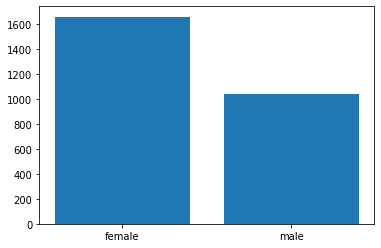

In [7]:
plt.bar(df_train["gender"].unique(), df_train["gender"].value_counts())

* 여성 사진이 조금 더 많음.

In [8]:
df_train["race"].unique()

array(['Asian'], dtype=object)

* 모든 데이터셋에 나오는 사람은 아시아인. race column은 drop해도 좋을 것 같음.

In [49]:
df_train["age"].describe()

count    2700.000000
mean       37.708148
std        16.985904
min        18.000000
25%        20.000000
50%        36.000000
75%        55.000000
max        60.000000
Name: age, dtype: float64

<BarContainer object of 3 artists>

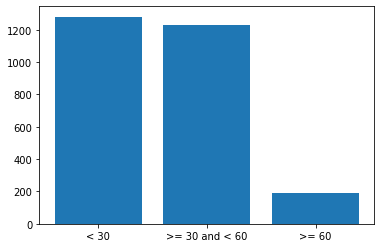

In [10]:
age1 = (df_train["age"] < 30).sum()
age2 = (df_train["age"].between(30, 59.9, inclusive=True)).sum()
age3 = (df_train["age"] >= 60).sum()
plt.bar(["< 30", ">= 30 and < 60", ">= 60"], [age1, age2, age3])

* 나이의 최댓값은 60살, 최소값은 18살.
* 30대 미만과, 30대 이상 60대 미만의 분포는 비슷, 60대 이상(60살)은 매우 적음.

In [37]:
train_Xy["class"].value_counts()

4     4085
3     3698
0     2809
1     2050
10     817
16     817
15     713
9      713
5      545
12     517
6      517
2      415
13     410
7      410
17     109
11     109
14      83
8       83
Name: class, dtype: int64

-----------------

### X값 EDA(image)

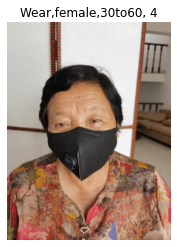

In [60]:
# image index로 출력
# sample = train_Xy[train_Xy["class"] == 8].iloc[0]
sample_index = 21
sample = train_Xy.iloc[sample_index]
path = sample["image_path"]
class_int = sample["class"]
class_name = ",".join([sample["masked"], sample["sex"], sample["age"]])

image = cv2.imread(path) 
plt.title(class_name + ", " + str(class_int))
plt.axis("off")
plt.imshow(image[:,:,::-1])

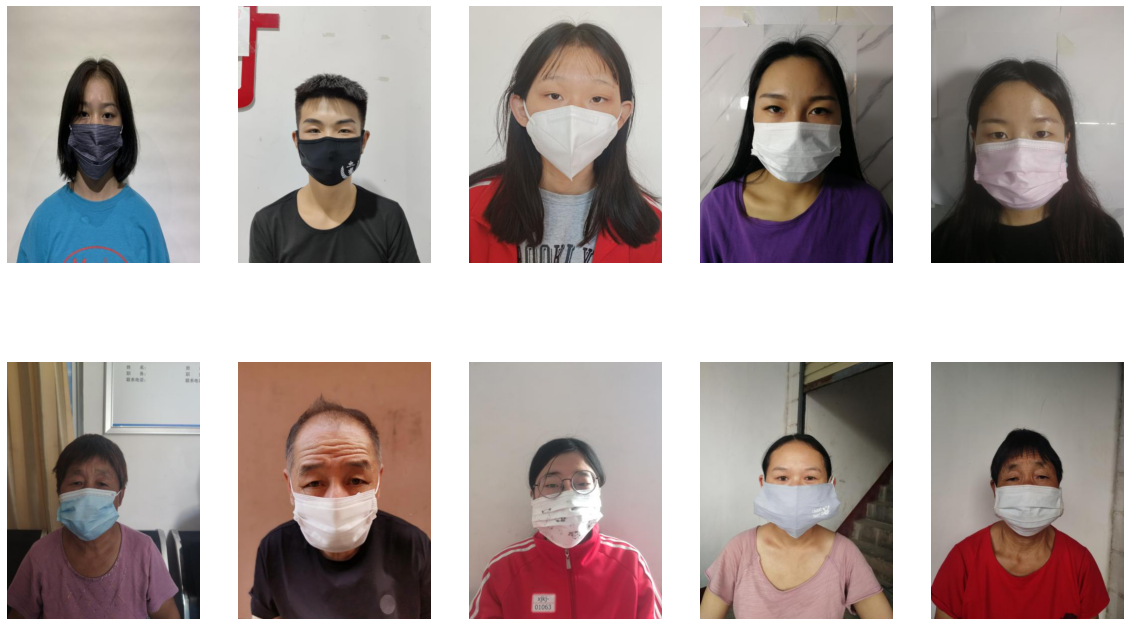

In [69]:
# 마스크 이미지
plt.figure(figsize=(20, 12))
weared_image = train_Xy[train_Xy["masked"] == "Wear"]["image_path"].sample(n=10)

for i, img in enumerate(weared_image[:10]):
    img = cv2.imread(img)
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(img[:,:,::-1])

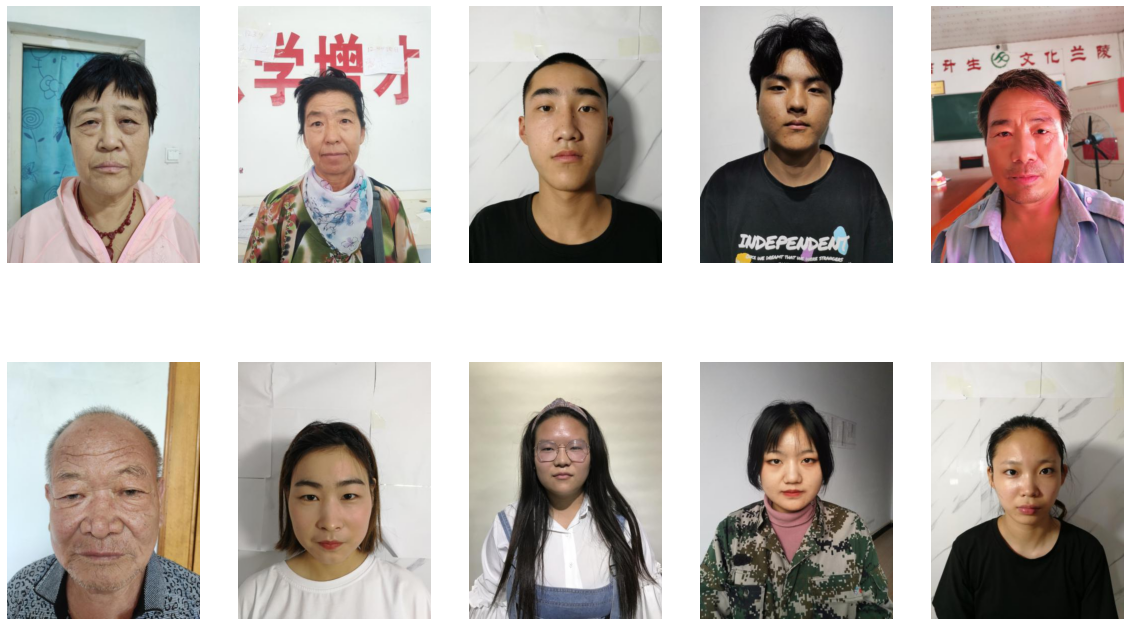

In [70]:
# 마스크 쓰지않은 이미지
plt.figure(figsize=(20, 12))
weared_image = train_Xy[train_Xy["masked"] == "NotWear"]["image_path"].sample(n=10)

for i, img in enumerate(weared_image[:10]):
    img = cv2.imread(img)
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(img[:,:,::-1])

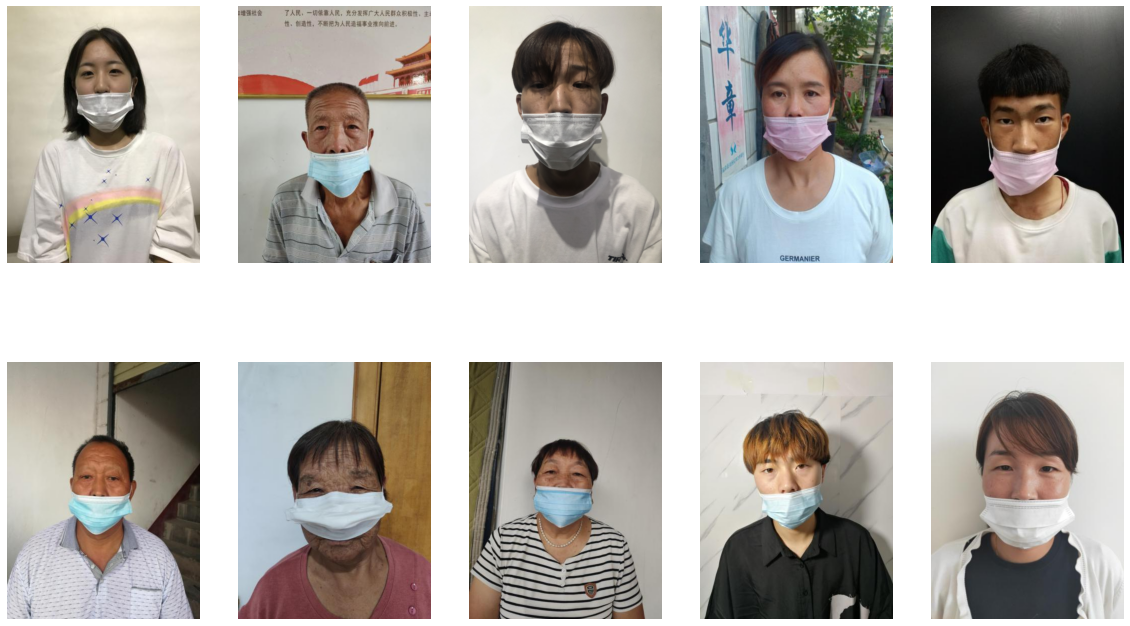

In [79]:
# 잘못된 이미지
plt.figure(figsize=(20, 12))
weared_image = train_Xy[train_Xy["masked"] == "Incorrect"]["image_path"].sample(n=10)

for i, img in enumerate(weared_image[:10]):
    img = cv2.imread(img)
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(img[:,:,::-1])

* 잘못된 마스크는 턱이 나오거나, 코가 나오는 경우.
* 대부분은 코가 나오는 이미지로 구성됨.
* 나중에 augmentation및 모델링 시 코와 턱을 함께 보면 좋을 것.

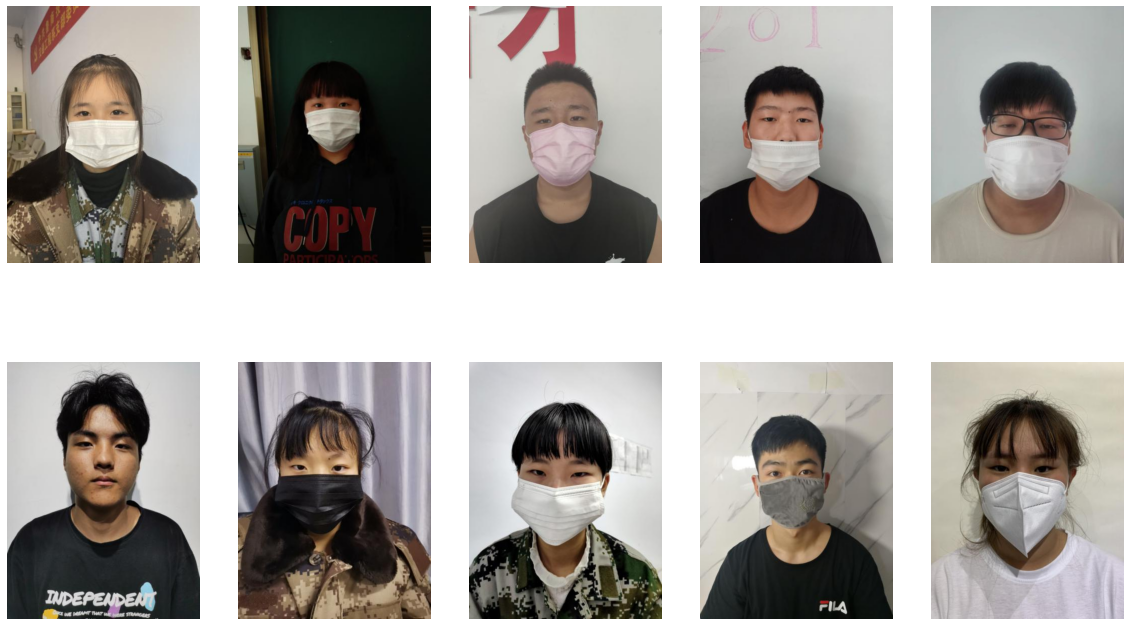

In [80]:
# 30세 이하
plt.figure(figsize=(20, 12))
weared_image = train_Xy[train_Xy["age"] == "Under30"]["image_path"].sample(n=10)

for i, img in enumerate(weared_image[:10]):
    img = cv2.imread(img)
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(img[:,:,::-1])

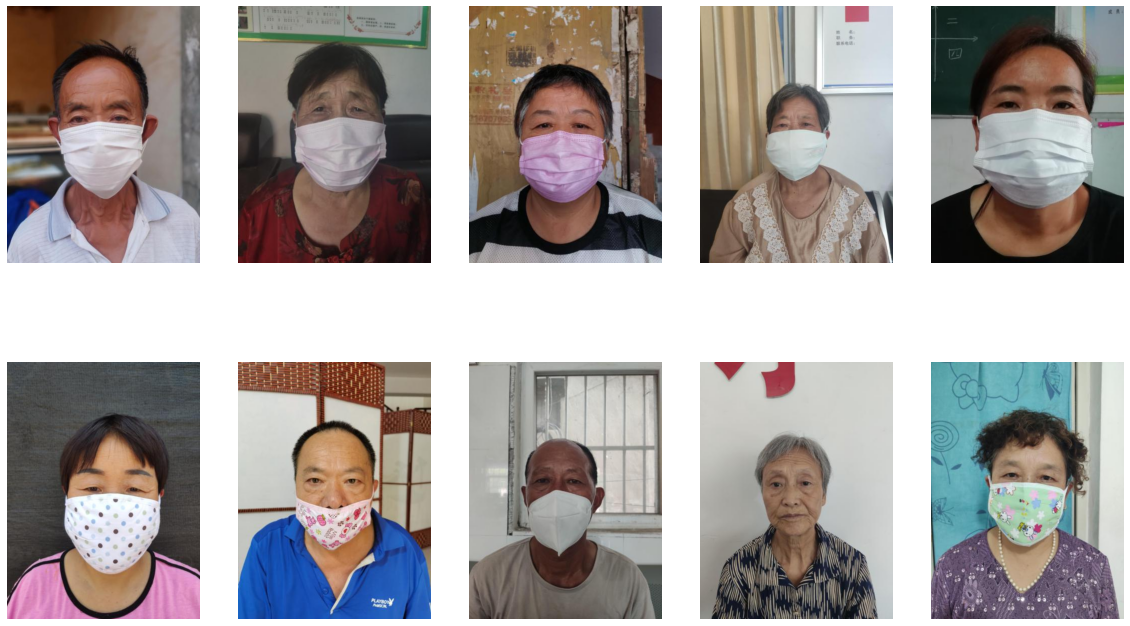

In [83]:
# 30~60세
plt.figure(figsize=(20, 12))
weared_image = train_Xy[train_Xy["age"] == "30to60"]["image_path"].sample(n=10)

for i, img in enumerate(weared_image[:10]):
    img = cv2.imread(img)
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(img[:,:,::-1])

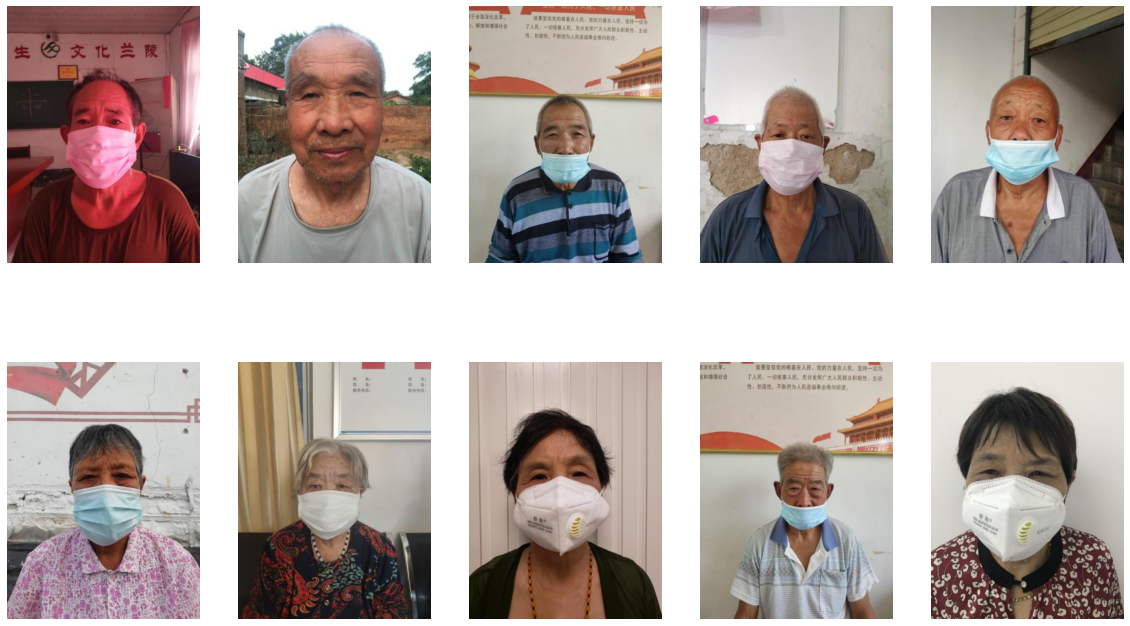

In [84]:
# 60세 이상
plt.figure(figsize=(20, 12))
weared_image = train_Xy[train_Xy["age"] == "Overeq60"]["image_path"].sample(n=10)

for i, img in enumerate(weared_image[:10]):
    img = cv2.imread(img)
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(img[:,:,::-1])

* age는 boundary의 구분이 상당히 힘들어보임.
* 특히, 30to60과 over 60은 구분하기가 힘듦(데이터상으로 60 이상이 없고 60살만 있는데, 60이상을 이렇게 표현한 건지 아니면 진짜로 60살 사진인지는 알 수 없음.)
* over 60를 좀 많이 만들어야 하지 않을까 생각(데이터수가 적어서 overfitting될수도 있으니 조심해야할 것 같음)